# Adaptive Error Model in MLDA

### Intro
This notebook (along with the utility code within the `./mlda` folder) is designed to demonstrate the adaptive error model feature of the Multi-Level Delayed Acceptance MCMC algorithm (MLDA) in PyMC3. The MLDA algorithm was proposed in [1], while the error modeling and correction feature has been taken from [2]. 

The MLDA sampler can be more efficient than other MCMC samplers when dealing with computationally intensive problems where we have access not only to the desired (fine) posterior distribution but also to a set of approximate (coarse) posteriors of decreasing accuracy and decreasing computational cost (for more details look at the introductory notebooks under `docs/source/notebooks/`.

For more details about the MLDA sampler and the way it should be used and parameterised, the user can refer to the introductory notebooks under `docs/source/notebooks/`, as well as the docstrings within the python code (the implementation is under `pymc3/step_methods/metropolis.py`). 

Please note that the MLDA sampler is new in pymc3. The user should be extra critical about the results and report any problems as issues in the pymc3's github repository.

The notebook results shown below were generated on a MacBook Pro with a 2.6 GHz 6-core Intel Core i7, 32 GB DDR4 and macOS 10.15.5.

### Adaptive Error Model
The idea of Adaptive Error Model (AEM) is to estimate the mean and variance of the forward-model error between successive levels, i.e. estimate the bias of the coarse forward model compared to the fine forward model. It uses those estimates to correct for the error. This helps smooth the differences between levels and thus allows more successful proposals from a level to the one above. Using the technique should improve ESS/sec on the fine level.

In existing literature (e.g. [2]), this method has been used primarily on 2-level problems. Here, we extend it to problems with any number of levels. In cases where there are more than 2 levels, we estimate biases between all pairs of levels and then we correct each level using its own correction plus all corrections from higher levels, e.g. if we have levels 0, 1 and 2 (where 2 is the finest level), level 0 is corrected by adding the 0 -> 1 correction and the 1 -> 2 correction. In this way, all levels attempt to estimate the finest level.

For more details about the method, please refer to section 3.2 of [2]. We have implemented Algorithm 4 without the adaptation in the base chain (although this will be added in the future). Also, we do the recursive mean and covariance calculation not according to equation (8) of [2] but according to equation (3) of [3] (which has been tested to work correctly in simulations).

The method assumes that the error between successive forward model outputs is normal-distributed and that the error introduced by the modelling process is also normal. This allows the method to work as described in the paper. In order to use AEM with a non-normal model, modification to the MCMC internals and the model description template would be needed. 

### Guide to writing the model definition and calling MLDA when using AEM
Using the AEM method within MLDA requires the likelihood of the model to be adaptive and a forward model to be defined and fed to the sampler. The user needs to do the following (as demonstrated in the steps of the code below):
- Include in the model definition at all coarseness levels, the extra variable `model_output`, which will capture the forward model outputs. Also include in the model definition at all levels except the finest one, the extra variables `mu_B` and `Sigma_B`, which will capture the bias between different levels. All these variables should be instantiated using the `pm.Data` method.
- Use a Theano Op to define the forward model (and optionally the likelihood) for all levels. The Op needs to store the result of each forward model calculation to the variable `model_output` of the PyMC3 model.
- Define a Multivariate Normal likelihood (either using the standard PyMC3 API or implementing it yourself inside an Op) which has mean equal to the forward model output plus `mu_B` and covariance equal to the model error plus `Sigma_B`.

Given the above, MLDA will capture and iteratively update the bias terms internally for all level pairs and will correct each level so that all levels' forward models aim to estimate the finest level's forward model.

### The model and PDE solver details
Please refer to `./MLDA_multilevel_groundwater_flow.ipynb` for more details.

### Dependencies
The code has been developed and tested with Python 3.6. You will need to have pymc3 installed and also [FEniCS](https://fenicsproject.org/) for your system. FEniCS is a popular, open-source, [well documented](https://fenicsproject.org/documentation/), high-performance computing framework for solving Partial Differential Equations. FEniCS can be [installed](https://fenicsproject.org/download/) either through their prebuilt Docker images, from their Ubuntu PPA, or from Anaconda. 
  

### References
[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X

[2] Cui, Tiangang & Fox, Colin & O'Sullivan, Michael. (2012). Adaptive Error Modelling in MCMC Sampling for Large Scale Inverse Problems.

[3] Haario, Heikki; Saksman, Eero; Tamminen, Johanna. An adaptive Metropolis algorithm. Bernoulli 7 (2001), no. 2, 223--242. https://projecteuclid.org/euclid.bj/1080222083

### Import modules

In [4]:
import os as os
import sys as sys
import time as time

from itertools import product

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt

import pymc3 as pm

sys.path.insert(1, 'mlda/') # import groundwater flow model utils (including FEniCS code)
from Model import Model, model_wrapper, project_eigenpairs

In [6]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 123446
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

### Set parameters

In [7]:
# Restrict BLAS to operate on a single thread at a time,
# since multithreading doesn't play well with multiple parallel chains
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [8]:
# Set the resolution of the multi-level models (from coarsest to finest)
# This is a list of different model resolutions. Each
# resolution added to the list will add one level to the multi-level
# inference. Each element is a tuple (x,y) where x, y are the number of 
# points in each dimension. For example, here we set resolutions = 
# [(4, 4), (20, 20), (80, 80)] which creates a coarse, cheap 4x4 model,
# a finer 20x20 model and the finest, expensive 80x80 model.
resolutions = [(4, 4), (20, 20), (120, 120)]

# Set random field parameters
field_mean = 0
field_stdev = 1
lamb_cov = 0.1

# Set the number of unknown parameters (i.e. dimension of theta in posterior)
nparam = 3

# Number of draws from the distribution
ndraws = 5000

# Number of burn-in samples
nburn = 2000

# MLDA tuning parameters
discard_tuning = True

# Number of independent chains
nchains = 4

# Subsampling rate for MLDA
nsub = 5

# Set the sigma for inference
sigma = 0.01

# Data generation seed
data_seed = RANDOM_SEED

# Sampling seed
sampling_seed = RANDOM_SEED

# Datapoints list
points_list = [0.1, 0.3, 0.5, 0.7, 0.9]

### Define the forward model using a Theano Op (that is compatible with AEM)
Here, we define a forward model using an Op. Inside the Op, we make use of the Data class of PyMC3 to pass the forward model output to the PyMC3 model (stored in variable `model_output`). Doing this gives the MLDA sampler access to the model output. The user needs to include this storage operation to `model_output` in the Op if they want to use the adaptive error model feature. 

Note that in this case the Op happens to use FEniCS external code (imported earlier) to calculate the forward model but this is not required (it could simply use python code).

In [9]:
class ForwardModel_AEM(tt.Op):
    """
    Theano Op that wraps the forward model computation,
    necessary to pass "black-box" fenics code into pymc3.
    
    This model is written so that it can be used in combination
    with the MLDA's adaptive error model (AEM)
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model) and returning a vector of model outputs
    itypes = [tt.dvector]  # expects a vector of parameter values (theta)
    otypes = [tt.dvector]  # outputs a vector of model outputs

    def __init__(self, my_model, x, pymc3_model):
        """
        Initialise the Op with various things that our forward model function
        requires.

        Parameters
        ----------
        my_model:
            A Model object (defined in file model.py) that contains the parameters
            and functions of our model.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        pymc3_model:
            The PyMC3 model being used.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.x = x
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs[0]  # this will contain my variables

        # call the forward model function
        temp = model_wrapper(self.my_model, theta, self.x)
        
        # NOTE: This line need to be included in the perform() function is you want to use AEM
        # It saves the forward model output to a data variable (`model_output`) within the PyMC3 model
        # this allows PyMC3 to access the value during sampling
        self.pymc3_model.model_output.set_value(temp)
            
        # write to output
        outputs[0][0] = temp

### Define the forward model using a Theano Op (without compatibility to AEM)
Here, we define the same forward model using an Op but in this case we do not save the variable `model_output`. This is Op can be used without the adaptive error model feature. 

In [10]:
class ForwardModel(tt.Op):
    """
    Theano Op that wraps the forward model computation,
    necessary to pass "black-box" fenics code into pymc3. 
    
    This is not compatible to AEM.
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model) and returning a vector of model outputs
    itypes = [tt.dvector]  # expects a vector of parameter values (theta)
    otypes = [tt.dvector]  # outputs a vector of model outputs

    def __init__(self, my_model, x):
        """
        Initialise the Op with various things that our forward model function
        requires.

        Parameters
        ----------
        my_model:
            A Model object (defined in file model.py) that contains the parameters
            and functions of our model.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.        
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.x = x

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs[0]  # this will contain my variables

        # call the forward model function
        temp = model_wrapper(self.my_model, theta, self.x)
                    
        # write to output
        outputs[0][0] = temp

### Instantiate Model objects and data
Here, we instantiate models for all levels/resolutions using the Model class imported earlier. We then generate data that will be used for inference. The objects created can be used both with and without AEM.

In [11]:
# Note this can take a few minutes for large resolutions
my_models = []
for r in resolutions:
    my_models.append(Model(r, field_mean, field_stdev, nparam, lamb_cov))

# Project eignevactors from fine model to all coarse models
for i in range(len(my_models[:-1])):
    project_eigenpairs(my_models[-1], my_models[i])

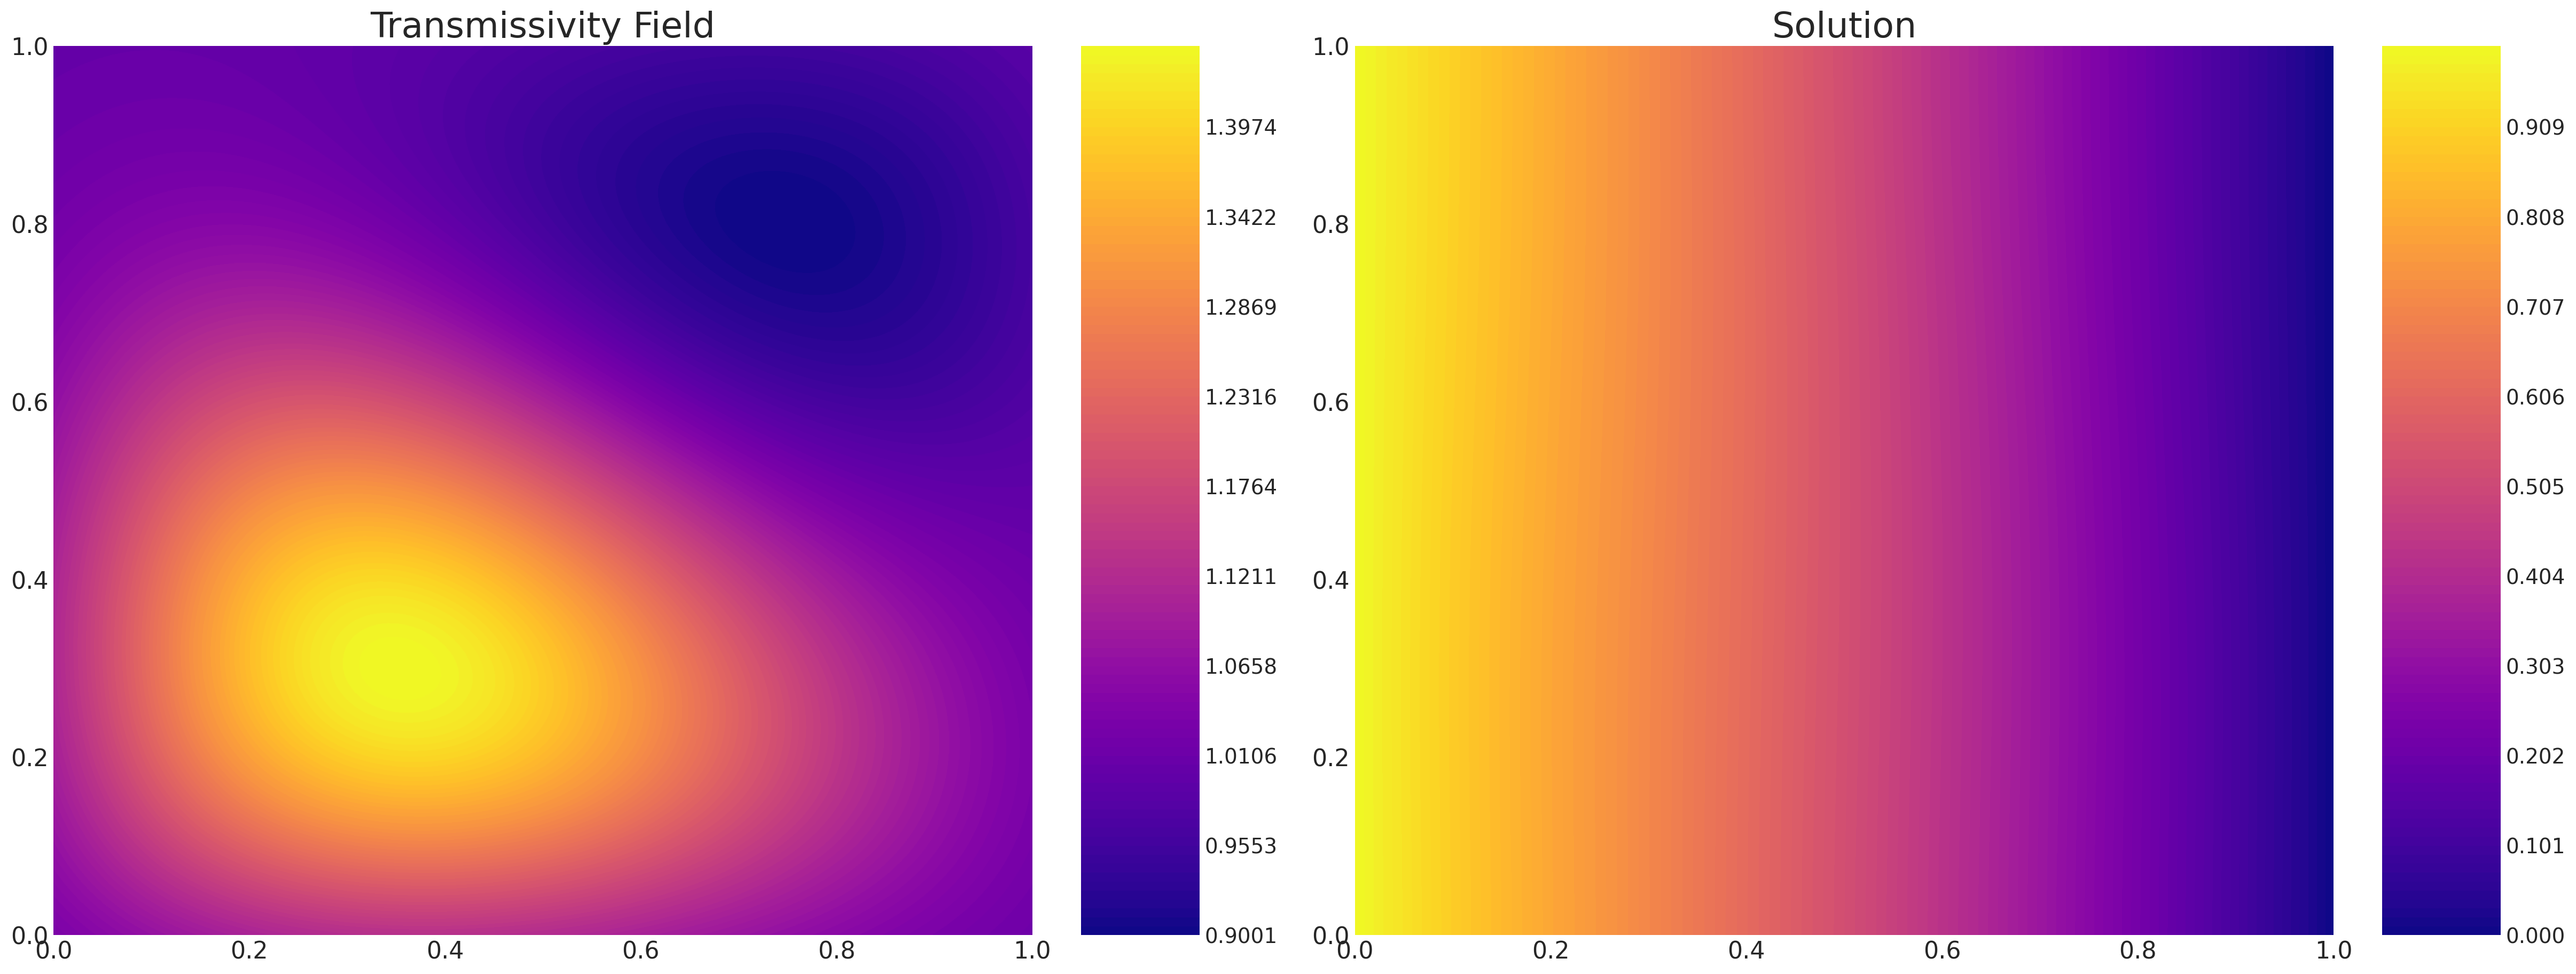

In [12]:
# Solve finest model as a test and plot transmissivity field and solution
np.random.seed(data_seed)
my_models[-1].solve()
my_models[-1].plot(lognormal=False)

# Save true parameters of finest model
true_parameters = my_models[-1].random_process.parameters

In [13]:
# Define the sampling points.
x_data = y_data = np.array(points_list)
datapoints = np.array(list(product(x_data, y_data)))

# Get data from the sampling points and perturb it with some noise.
noise = np.random.normal(0, 0.001, len(datapoints))

# Generate data from the finest model for use in pymc3 inference - these data are used in all levels
data = model_wrapper(my_models[-1], true_parameters, datapoints) + noise

# Create covariance matrix of normal error - it is a diagonal matrix
s = np.identity(len(data))
np.fill_diagonal(s, sigma**2)

### Construct pymc3 model objects for coarse models (with AEM)
This defines PyMC3 models for each level - excluding finest model level

In [14]:
coarse_models = []
mout = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # mu_B and Sigma_B are the mean and covariance of the bias
        # between this forward model and the model one level below. The bias is due
        # to different levels of coarseness, i.e. resolutions.
        # Both are initialised with zeros.
        # These will be updated in each iteration of this level's chain
        mu_B = pm.Data('mu_B', np.zeros(len(data)))
        Sigma_B = pm.Data('Sigma_B', np.zeros((len(data), len(data))))
        
        # This will be used to store the output of the forward model produced by the Op
        # The user needs to save the model output to this variable inside the 
        # perform() method of the Op
        model_output = pm.Data('model_output', np.zeros(len(data)))

        # Sigma_e is the covariance of the assumed error 'e' in the model.
        # This error is due to measurement noise/bias vs. the real world
        Sigma_e = pm.Data('Sigma_e', s)

        # uniform priors on unknown parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert thetas to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # Here we instatiate a ForwardModel_AEM using the class defined above 
        # (which wraps the fenics model code) and we add to the mout list
        mout.append(ForwardModel_AEM(my_models[j], datapoints, model))
                
        # The distribution of the error 'e' (assumed error of the forward model)
        # This is multi-variate normal where:
        # - the mean is equal to the forward model output plus the bias correction term mu_B
        # - the covariance is equal to the forward model covariance Sigma_e plus the bias correction term Sigma_B
        # This creates the likelihood of the model given the observed data
        pm.MvNormal('e', mu=mout[j](theta) + mu_B, cov=Sigma_e + Sigma_B, observed=data)

    coarse_models.append(model)

### Perform inference using MLDA (with AEM)
Here we define the finest model and perform inference with PyMC3, using MLDA with AEM

Note that in the finest model definition we do not need the variables `mu_B` and `Sigma_B`, since the finest model is not corrected.

In [15]:
method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

with pm.Model() as fine_model:
    # This will be used to store the output of the forward model produced by the Op
    # The user needs to save the model output to this variable inside the 
    # perform() method of the Op
    model_output = pm.Data('model_output', np.zeros(len(data)))

    # Sigma_e is the covariance of the assumed error 'e' in the model.
    # This error is due to measurement noise/bias vs. the real world
    Sigma_e = pm.Data('Sigma_e', s)

    # uniform priors on unknown parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # Here we instatiate a ForwardModel_AEM using the class defined above 
    # (which wraps the fenics model code) and we add to the mout list
    mout.append(ForwardModel_AEM(my_models[-1], datapoints, fine_model))      

    # The distribution of the error 'e' (assumed error of the forward model)
    # Note that here we *do not* correct the mean and covariance since this is the finest model
    pm.MvNormal('e', mu=mout[-1](theta), cov=Sigma_e, observed=data)

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list and activate AEM
    step_mlda_with = pm.MLDA(subsampling_rate=nsub, coarse_models=coarse_models,                             
                             adaptive_error_model=True)    
    
    # inference
    t_start = time.time()
    method_names.append("MLDA_with_AEM")
    traces.append(pm.sample(draws=ndraws, step=step_mlda_with,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed,
                            cores=1))
    runtimes.append(time.time() - t_start)

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1063: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1063: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Sequential sampling (4 chains in 1 job)
MLDA: [theta_2, theta_1, theta_0]


### Construct pymc3 model objects for coarse models (without AEM)
This defines PyMC3 models for each level - excluding finest model level.

Notice that here we do not use any of the special variables that we used without AEM.

In [16]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
mout = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # Sigma_e is the covariance of the assumed error 'e' in the model.
        # This error is due to measurement noise/bias vs. the real world
        Sigma_e = pm.Data('Sigma_e', s)

        # uniform priors on unknown parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert thetas to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # Here we instatiate a ForwardModel and pass the model as argument
        mout.append(ForwardModel(my_models[j], datapoints))
        
        # The distribution of the error 'e' (assumed error of the forward model)
        # This is multi-variate normal where:
        # - the mean is equal to the forward model output
        # - the covariance is equal to the forward model covariance Sigma_e
        # This creates the likelihood of the model given the observed data
        pm.MvNormal('e', mu=mout[j](theta), cov=Sigma_e, observed=data)

    coarse_models.append(model)

### Perform inference using MLDA (without AEM)
Here we sample from the posterior using MLDA without AEM

In [17]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
with pm.Model() as fine_model:
    # Sigma_e is the covariance of the assumed error 'e' in the model.
    # This error is due to measurement noise/bias vs. the real world
    Sigma_e = pm.Data('Sigma_e', s)

    # uniform priors on unknown parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # Here we instatiate a ForwardModel and pass the model as argument
    mout.append(ForwardModel(my_models[-1], datapoints))
    
    # The distribution of the error 'e' (assumed error of the forward model)
    pm.MvNormal('e', mu=mout[-1](theta), cov=Sigma_e, observed=data)

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list    
    step_mlda_without = pm.MLDA(subsampling_rate=nsub, coarse_models=coarse_models,                             
                             adaptive_error_model=False)
    
    # inference
    t_start = time.time()
    method_names.append("MLDA_without_AEM")
    traces.append(pm.sample(draws=ndraws, step=step_mlda_without,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed,
                            cores=1))
    runtimes.append(time.time() - t_start)


for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(ar.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1063: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_with_AEM: 5000 drawn samples in each of 4 chains.
Runtime: 7351.343003988266 seconds
Acceptance rate: 0.93375
ESS list: [17461.91149827 17721.6686422  17404.53046373]
Normalised ESS list: [0.87309557 0.88608343 0.87022652]
ESS/sec: [2.37533625 2.4106709  2.36753073]


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_without_AEM: 5000 drawn samples in each of 4 chains.
Runtime: 5179.33412194252 seconds
Acceptance rate: 0.4336
ESS list: [3539.80403407 4646.59411002 5077.49437996]
Normalised ESS list: [0.1769902  0.23232971 0.25387472]
ESS/sec: [0.68344771 0.89714122 0.98033729]


### Compare performance

In [18]:
print(f"\nMLDA+AEM vs. MLDA performance speedup in all dimensions (performance measured by ES/sec):\n{np.array(performances[0]) / np.array(performances[1])}")


MLDA+AEM vs. MLDA performance speedup in all dimensions (performance measured by ES/sec):
[3.4755201  2.68705847 2.4150165 ]


### Show stats summary

In [19]:
print(f"\nDetailed summaries and plots:\nTrue parameters: {true_parameters}")
for i, trace in enumerate(traces):
    print(f"\nSampler {method_names[i]}:\n", pm.stats.summary(trace))


Detailed summaries and plots:
True parameters: [-0.46637009  0.5045304   0.10894868]


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_with_AEM:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
theta_0 -0.460  0.163  -0.758   -0.149      0.001    0.001   17458.0  17458.0   
theta_1  0.471  0.156   0.166    0.754      0.001    0.001   17727.0  17645.0   
theta_2  0.077  0.156  -0.216    0.368      0.001    0.001   17413.0  17413.0   

         ess_bulk  ess_tail  r_hat  
theta_0   17462.0   17930.0    1.0  
theta_1   17722.0   17674.0    1.0  
theta_2   17405.0   17168.0    1.0  


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_without_AEM:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta_0 -0.462  0.162  -0.760   -0.155      0.003    0.002    3540.0  3540.0   
theta_1  0.471  0.157   0.187    0.770      0.002    0.002    4664.0  4664.0   
theta_2  0.078  0.156  -0.197    0.386      0.002    0.002    5097.0  5097.0   

         ess_bulk  ess_tail  r_hat  
theta_0    3540.0    5399.0    1.0  
theta_1    4647.0    5762.0    1.0  
theta_2    5077.0    6285.0    1.0  


### Show traceplots

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


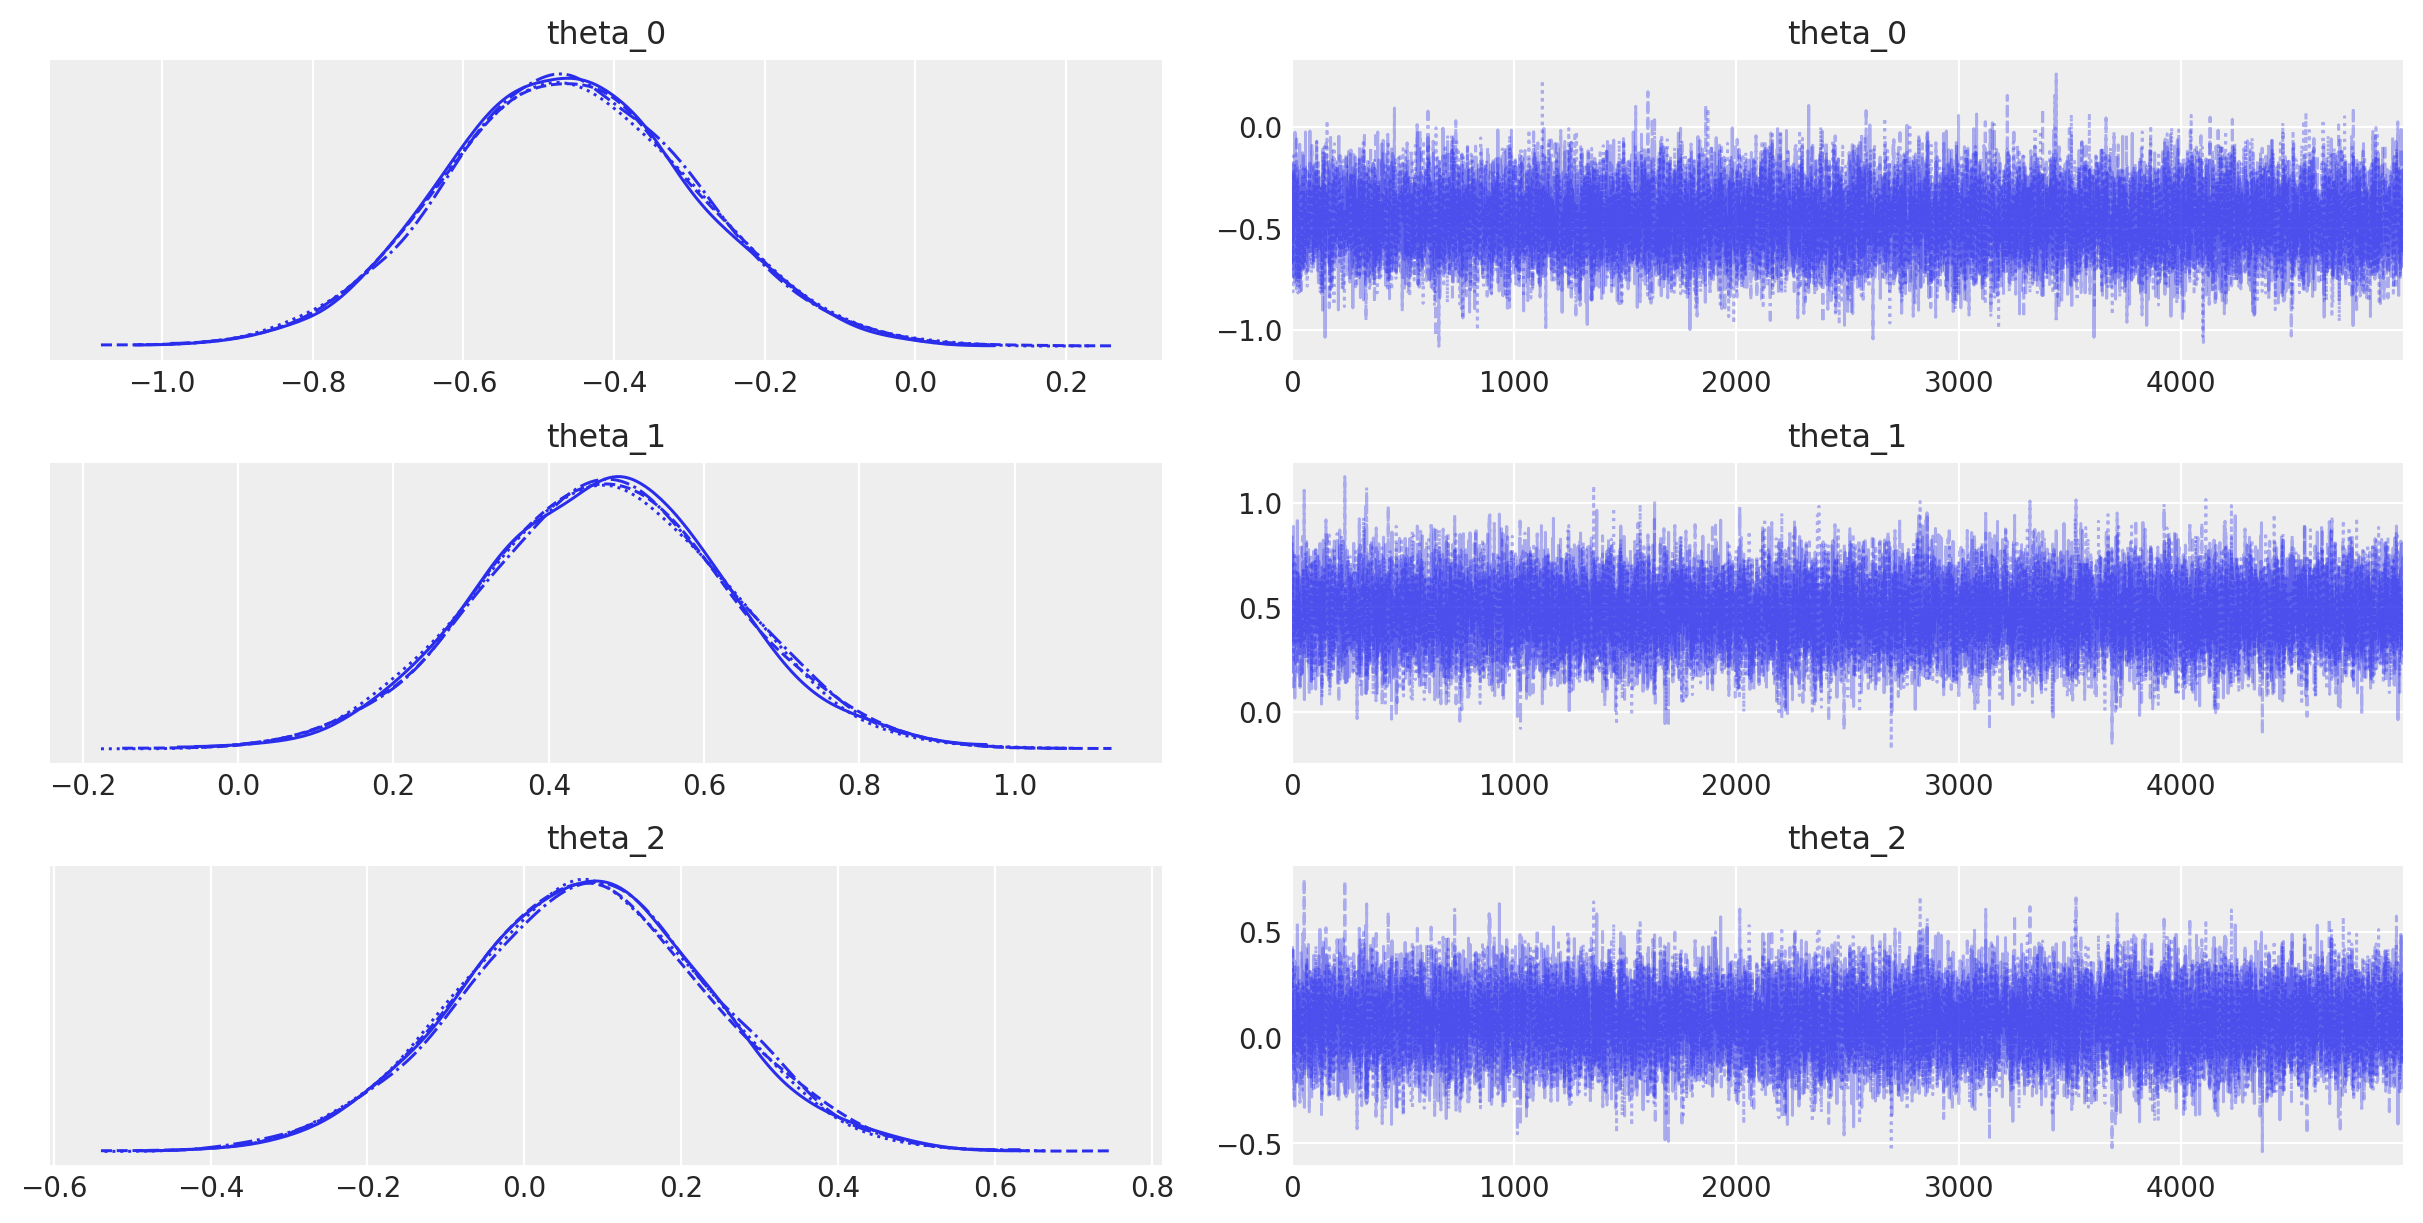

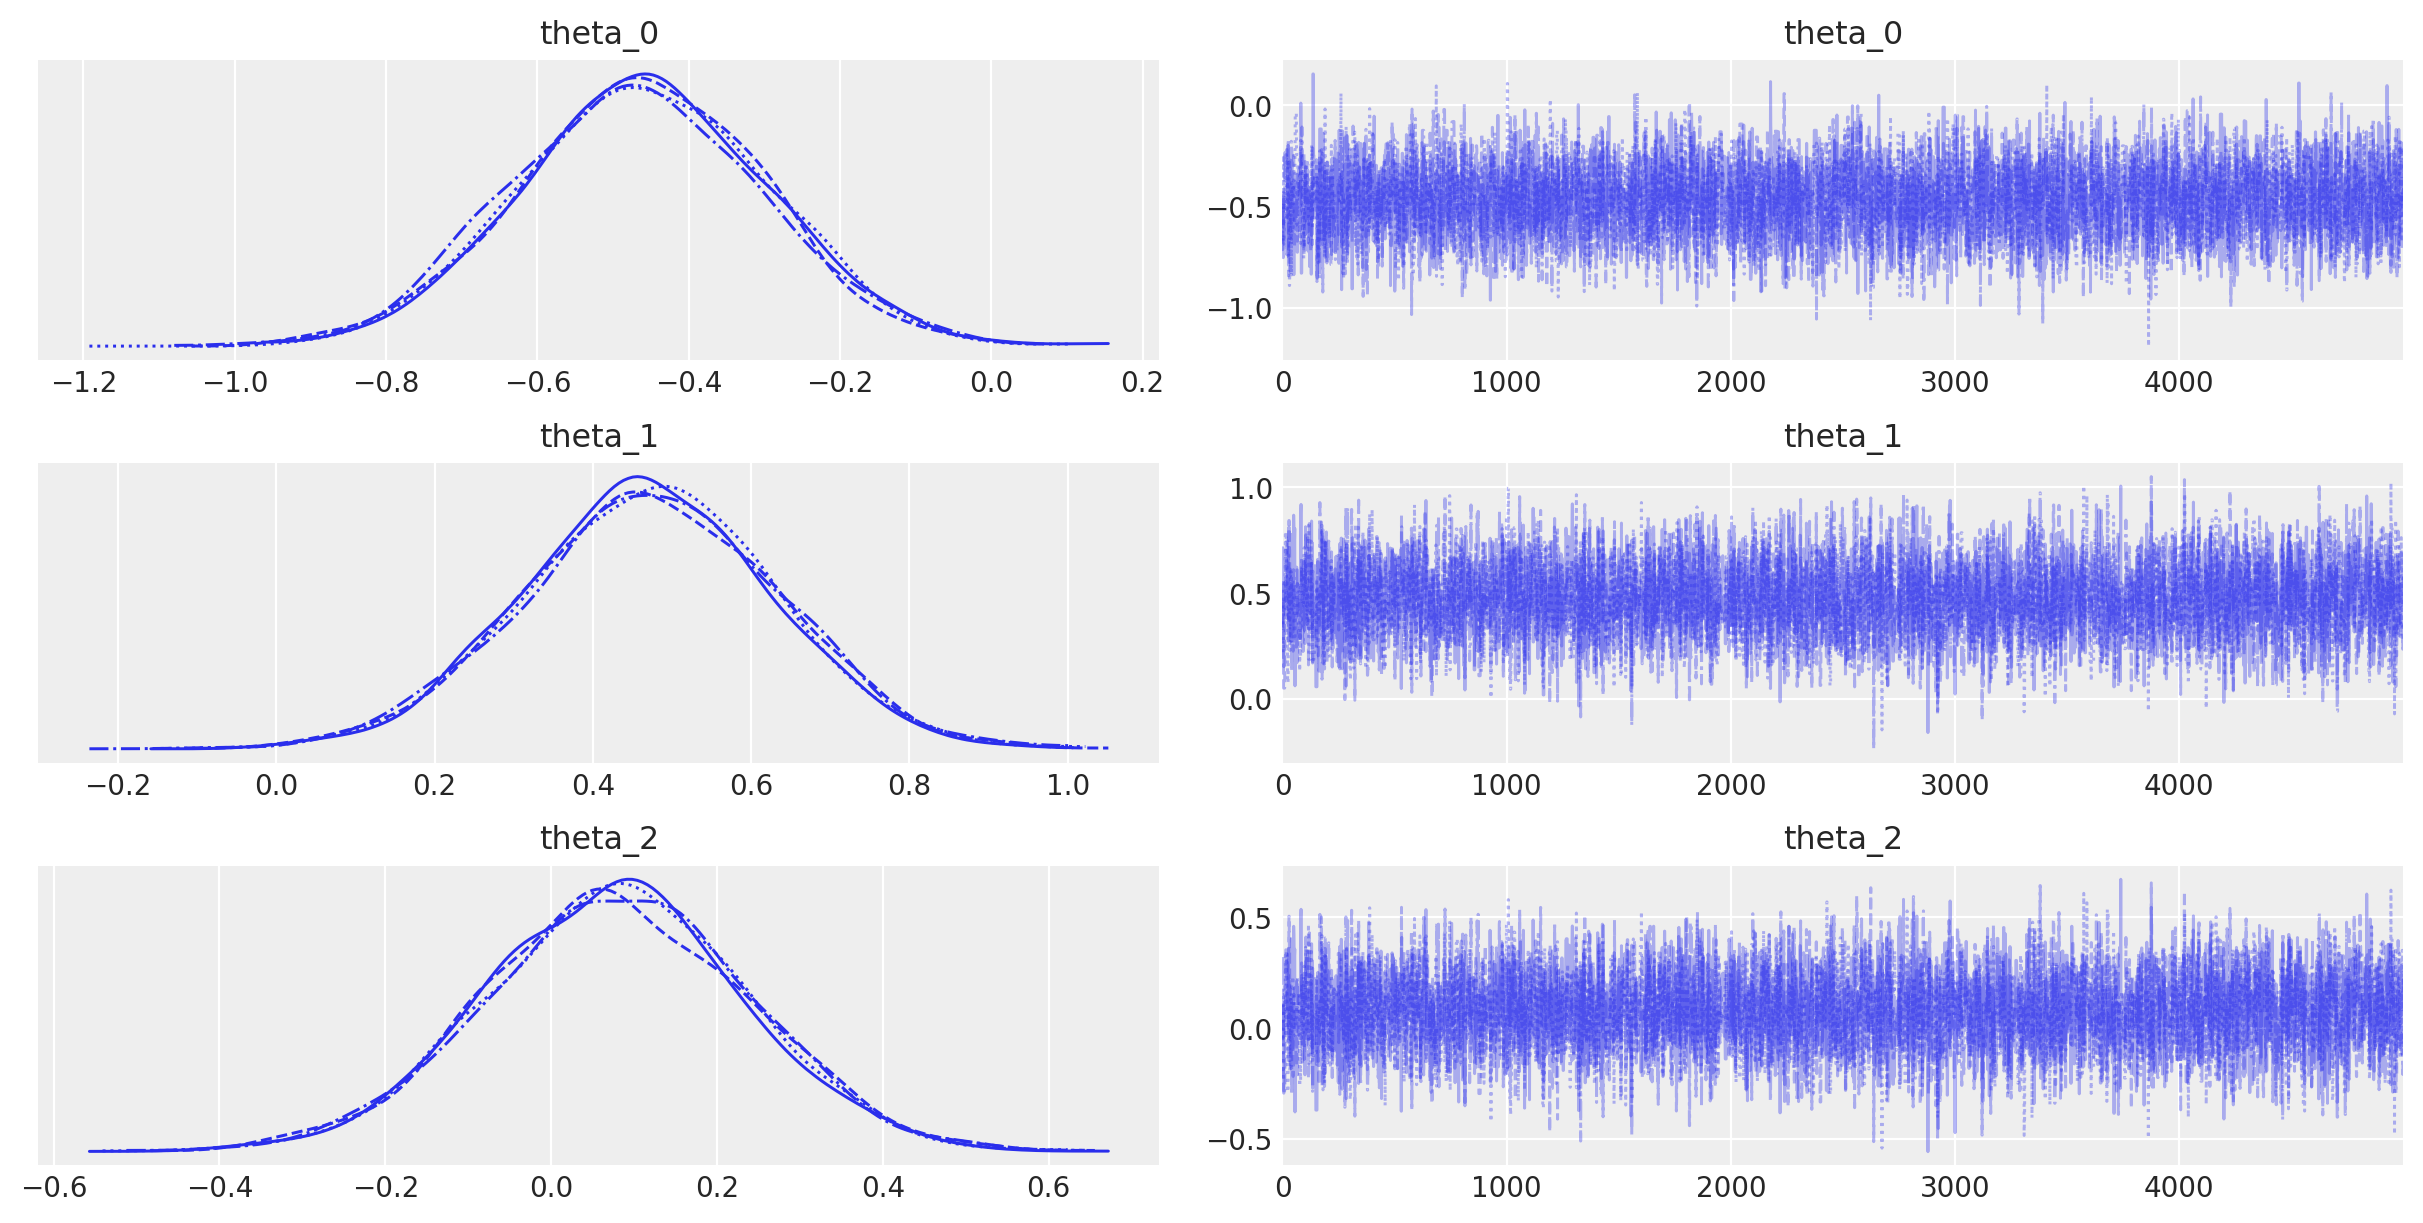

In [20]:
# Print true theta values and pymc3 sampling summary
for i, trace in enumerate(traces):
    pm.plots.traceplot(trace)

In [21]:
# Make sure samplers have converged
rh = [az.rhat(trace) for trace in traces ]
for i in rh:    
    assert all(np.array([i.data_vars[var].data for var in ['theta_0', 'theta_1']]) < 1.03)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy 1.15.4
arviz 0.9.0
pymc3 3.9.3
last updated: Fri Sep 11 2020 

CPython 3.6.11
IPython 7.16.1
watermark 2.0.2
